In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Create link
# file_path = 'C:/Users/Dell/Documents/Data Preparation Project/dataset/'
file_path = 'D:\\Năm 3 - HK1\\Visualize\\Ex\\final_project\\dseb63_final_project_DP_dataset\\dseb63_final_project_DP_dataset\\'

#Import Data
app_train = pd.read_csv(file_path + "dseb63_application_train.csv", index_col='Unnamed: 0')
app_test = pd.read_csv(file_path + "dseb63_application_test.csv", index_col='Unnamed: 0')
bureau = pd.read_csv(file_path + "dseb63_bureau.csv")
bureau_balance = pd.read_csv(file_path + "dseb63_bureau_balance.csv")
POS_CASH_balance = pd.read_csv(file_path + "dseb63_POS_CASH_balance.csv")
previous_application = pd.read_csv(file_path + "dseb63_previous_application.csv")
credit_card_balance = pd.read_csv(file_path + "dseb63_credit_card_balance.csv")
installments_payments = pd.read_csv(file_path + "dseb63_installments_payments.csv")

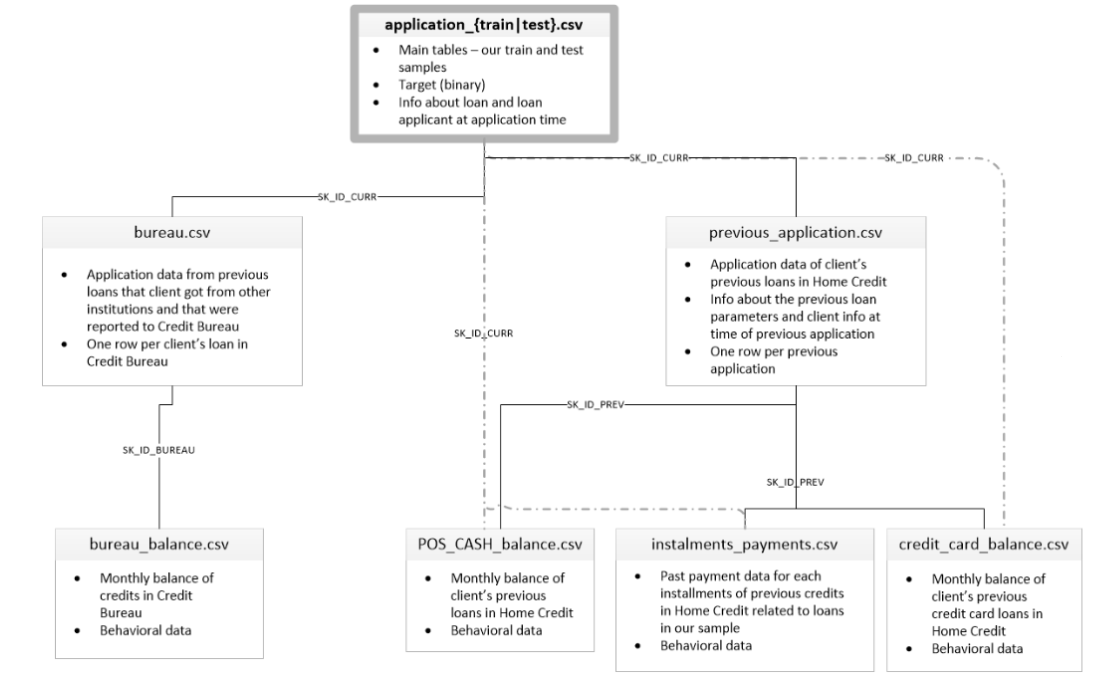

# MERGE DATA

In [2]:
def extract(x,on,prefix):
    # Create dictionary to classify which funtion to use with each feature
    order = {}
    num_feature = x.select_dtypes(['int','float']).columns.tolist()
    num_feature.remove(on)
    cat_feature = x.select_dtypes(['object']).columns.tolist()
    for i in num_feature:
        order[i] = 'mean'
    for i in cat_feature:
        order[i] = 'first'
    y = x.groupby(on, as_index=False).agg(order).add_prefix(prefix) 
    return y

def merge_table(df_child,df_parent, on, prefix, drop_on = False):
    '''Merge parent dataframe (df_parent) with child dataframe (df_child)
    by column (on), add prefix on child data to easily recognize.
    Decide whether to drop column on (drop_on) after using it.'''
    
    # Add a feature that counts times of one ID appears
    child_count = df_child.groupby(on)[[on]].count().rename(columns = {on: prefix+'COUNT'})
    df_parent = df_parent.merge(child_count, on = on, how = 'left')

    # Prepare child data and merge with parent data 
    df_child = extract(df_child,on,prefix)
    df_child = df_child.rename(columns = {prefix+on : on})
    df_parent = df_parent.merge(df_child, on = on, how ='left')
    
    # Drop column 'on'
    if drop_on == True:
        df_parent.drop(on, axis = 1, inplace = True)
    return df_parent

In [5]:
# Merge train and test set
data = pd.concat([app_train,app_test], ignore_index=True)

In [6]:
# Merge bureau with bureau_balance
bureau = merge_table(bureau_balance, bureau, 'SK_ID_BUREAU', 'BUR_BAL_', drop_on=True)
# Merge bureau with application set
data = merge_table(bureau, data, 'SK_ID_CURR', 'PREV_BUR_')

In [7]:
# Drop un-used column
credit_card_balance.drop('SK_ID_CURR', axis = 1, inplace = True)
installments_payments.drop('SK_ID_CURR', axis = 1, inplace = True)
POS_CASH_balance.drop('SK_ID_CURR', axis = 1, inplace = True)

# Merge credit_card_balance with previous_application
previous_application = merge_table(credit_card_balance, previous_application, on = 'SK_ID_PREV', prefix='CREDIT_CARD_' )

# Merge installments_payments with previous_application
previous_application = merge_table(installments_payments, previous_application, on = 'SK_ID_PREV', prefix='INSTALL_' )

# Merge POS_CASH_balance with previous_application
previous_application = merge_table(POS_CASH_balance, previous_application, on = 'SK_ID_PREV', prefix='POS_' , drop_on=True)

# Merge previous_application with data
data = merge_table(previous_application, data, on = 'SK_ID_CURR', prefix='PRE_APPLY_')

# ADD NEW FEATURES

In [9]:
def stats_by_cate(df,cate,feature):
    """ Extract numeric statistics (mean, max, min, median) by class, categorical values"""

    m = df.groupby(cate)[feature].agg(['mean','median','min','max'])
    mean = m['mean']
    df[feature+'_mean_by_'+cate] = df[cate].replace(mean.index.tolist(),mean.values)

    # median  = m['median']
    # min = m['min']
    # max = m['max']

    df[feature+'_mean_by_'+cate] = df[cate].replace(mean.index.tolist(),mean.values)
    # df[feature+'_median_by_'+cate] = df[cate].replace(median.index.tolist(),median.values)
    # df[feature+'_min_by_'+cate] = df[cate].replace(min.index.tolist(),min.values)
    # df[feature+'_max_by_'+cate] = df[cate].replace(max.index.tolist(),max.values)


In [10]:
# # Income by categorical
# cates = ['REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','NAME_CONTRACT_TYPE',\
#          'FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',\
#               'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','ORGANIZATION_TYPE']

# # Finance rate


# data['GOODS_PRICE_INCOME_TOTAL_PER']=(data['AMT_INCOME_TOTAL']/data['AMT_GOODS_PRICE'])
# data['PAY_TOWARDS_LOAN'] = data['AMT_INCOME_TOTAL']-data['AMT_ANNUITY']
# data['INCOME_CREDIT_PER'] = (data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT'])

# data['GOODS_PRICE_CREDIT_PER']=(data['AMT_CREDIT']/data['AMT_GOODS_PRICE'])
# data['PAYMENT_RATE_INV'] = data['AMT_CREDIT'] / data['AMT_ANNUITY']
# data['PAYMENT_RATE_NEG'] = data['AMT_CREDIT'] - data['AMT_ANNUITY']

# data['GOODS_PRICE_AMT_ANNUITY_PER']=(data['AMT_ANNUITY']/data['AMT_GOODS_PRICE'])
# data['PAYMENT_RATE'] = (data['AMT_ANNUITY'] / data['AMT_CREDIT'])
    
# data['PREV_DEBT_RATE'] = (data['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT'] / data['PREV_BUR_MEAN_AMT_CREDIT_SUM']).replace(np.inf, 0)

# fin = ['AMT_INCOME_TOTAL','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_CREDIT','GOODS_PRICE_INCOME_TOTAL_PER',\
#        'GOODS_PRICE_CREDIT_PER','GOODS_PRICE_AMT_ANNUITY_PER',\
#               'PAYMENT_RATE','PREV_DEBT_RATE']
# for fea in fin:
#     for col in cates:
#        stats_by_cate(data,col,fea)


# # Family
# data['ADULTS'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
# # stats_by_cate(data,'ADULTS','AMT_INCOME_TOTAL')
# data['Income/adult'] = data['AMT_INCOME_TOTAL'] / data['ADULTS']
# data['income/person']= data['AMT_INCOME_TOTAL']/data['CNT_FAM_MEMBERS']

# # External source
# ext = data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]
# data['EXT_SOURCE_MEAN']=(ext).mean(axis=1)
# data['EXT_SOURCE_MIN']=ext.min(axis=1)
# data['EXT_SOURCE_MAX']=ext.max(axis=1)

# for i in ['EXT_SOURCE_MEAN','EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
#     for col in cates:
#        stats_by_cate(data,col,i)
#        print(col,i)
       
# data['highcorr'] = data['DAYS_BIRTH'] * data['EXT_SOURCE_1']
# data['highcorr2'] = data['DAYS_BIRTH'] / data['EXT_SOURCE_1']
# data['highcorr3'] = data['PREV_BUR_MEAN_DAYS_CREDIT'] * data['EXT_SOURCE_3']


# data['ADDRESS_MISSMATCH']=((data[['REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
#        'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']]).sum(axis=1))
    
# data['CONTACT_REF']=((data[['FLAG_MOBIL', 'FLAG_EMP_PHONE',
#        'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL']]).sum(axis=1))
    
# data['MAX_DAYS_SOMETHING_CHANGED']=((data[['DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
#        'DAYS_REGISTRATION']]).max(axis=1))
    

# # Inquiries count
# inquires = [ 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT','AMT_REQ_CREDIT_BUREAU_YEAR']
# inq = ['AMT_REQ_CREDIT_BUREAU_HOUR']
# days = [1,7,30,90,365]
# for i in range(len(inquires)):
#        inq.append(inquires.pop(0))
#        data['SUM_ENQUIRIES_'+str(i)]=((data[inq]).sum(axis=1))
#        data['AVG_DAY_INQUIRIES_'+str(i)] = days[i] / data['SUM_ENQUIRIES_'+str(i)]



# # EMploy stats
# data['DAYS_WORKING_PER']=data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
    
# data['DAYS_UNEMPLOYED']=abs(data['DAYS_BIRTH'])-abs(data['DAYS_EMPLOYED'])

# data['ANNUITY_DAYS_EMPLOYED_PERC'] = data['AMT_ANNUITY'] / data['DAYS_EMPLOYED']
    
# data['AMT_CREDIT_DAYS_EMPLOYED_PERC'] = data['AMT_CREDIT'] / data['DAYS_EMPLOYED']


# # Flag if its value filled
# a = (data.select_dtypes(['float','int']).isnull().sum()).sort_values(ascending=False).head(100).index.tolist()
# for i in range(len(a)):
#     flag = 'FLAG_'+str(i)
#     data[flag] = data[a[i]].apply(lambda x: 0 if np.isnan(x) else 1) 
#     print(i)

# MODELLING

In [11]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PowerTransformer, MinMaxScaler, StandardScaler

In [12]:
# Split data by Independent and Depentdent variable
y_train = data[data['TARGET'].isin([1,0])]['TARGET']
x = data.iloc[:,1:]

# Fill mode with object type feature
col = x.select_dtypes('object').columns.tolist()
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
categorical_imputer.fit(x[col])
x[col] = categorical_imputer.transform(x[col])
x = x.replace([-np.inf,np.inf],0)

# Fill median with numerical type feature
col2 = x.select_dtypes(['float','int']).columns.tolist()
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
numerical_imputer.fit(x[col2])
x[col2] = numerical_imputer.transform(x[col2])

# Onehot with categorical feature
x = pd.get_dummies(x)

# Split train and test set
x_train = x[x.SK_ID_CURR.isin(data[data['TARGET'].isin([1,0])]['SK_ID_CURR'])]
x_test = x[x.SK_ID_CURR.isin(data[~data['TARGET'].isin([1,0])]['SK_ID_CURR'])]

In [13]:
# Create pipeline
steps = [('pt', PowerTransformer()), 
        ('mm', MinMaxScaler()),
        ('rb', RobustScaler(quantile_range=(30,70))),
        ('model', LogisticRegression())]
pipeline = Pipeline(steps=steps)

pipeline.fit(x_train, y_train)
y_pred = pipeline.predict_proba(x_test)[:, 1]

In [15]:
# Evaluate
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,pipeline.predict_proba(x_train)[:, 1])

0.7666754055302338

In [14]:
# # Saved output
# submit = x_test[['SK_ID_CURR']]
# submit['TARGET'] = y_pred
# path = 'D:\\Năm 3 - HK1\\Visualize\\Ex\\final_project\\'
# submit.to_csv(path+'ad-01-12.csv')